In [1]:
import pandas as pd
import numpy as np
import random
import sys

from datetime import datetime as dt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gm
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [2]:
DATA_PATH = "../../data/02_intermediate/"

In [3]:
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

def all_colors():
    return ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
            "b", "g", "r", "c", "m", "y", "k",
            "limegreen", "cornflowerblue", "mediumblue", "darkorange", "maroon", "deepskyblue", "darkmagenta"]

def random_color():
    pallette = all_colors()
    return cc(random.choice(pallette))

def get_color(index):
    pallette = all_colors()
    return cc(pallette[index])

def all_lines():
    return ["-", "--", "-.", "."]

def all_markers():
    return [".", ",", "o", "v", "^", "1", "8", "*", "H", "d"]

def random_marker():
    return random.choice(all_markers())

In [4]:
def custom_scatter_2D(matrix, labels, cluster_centers, n_clusters, digit, coeffs=[0, 1]):
    """Scatter plot of 2 dimensions of kmeans results"""
    fig = plt.figure()
    ax = fig.add_subplot()

    clustered_matrix = parse_labels(matrix=matrix, labels=labels, n_clusters=n_clusters)
    # for cluster in clustered_matrix:
    for index in range(len(clustered_matrix)):
        cluster = clustered_matrix[index]
        xs = cluster[:, coeffs[0]]
        ys = cluster[:, coeffs[1]]
        ax.scatter(x=xs, y=ys, s=0.5, color=get_color(index=index), marker=random_marker())
    
    ax.set_xlabel(f"MFCC {coeffs[0]}")
    ax.set_ylabel(f"MFCC {coeffs[1]}")
    ax.set_title(f"K-Means Result for Digit {digit} with {n_clusters} Clusters")

    plt.show()

In [5]:
def create_filter_arr(labels, cluster):
    """Create boolean flagged filter array to apply to filter np array"""
    filter_arr = []
    for label in labels:
        if label == cluster:
            filter_arr.append(True)
        else:
            filter_arr.append(False)
    return filter_arr

def parse_labels(matrix, labels, n_clusters):
    """Filter matrix and labels into clustered matrices for scatter plotting"""
    clustered_matrix = []

    for cluster in range(n_clusters):
        filter_arr = create_filter_arr(labels=labels, cluster=cluster)
        sub_matrix = matrix[filter_arr]
        clustered_matrix.append(sub_matrix)

    return clustered_matrix

def analyze_cluster(matrix, labels, cluster_centers, n_clusters):
    """Compute covariance and pi value for gmm vars of clusters"""
    covariance_matrix = []
    pi_matrix = []

    for cluster in range(n_clusters):
        filter_arr = create_filter_arr(labels=labels, cluster=cluster)
        sub_matrix = matrix[filter_arr]

        pi = len(sub_matrix) / len(matrix)
        covariance = np.cov(np.transpose(sub_matrix))

        pi_matrix.append(pi)
        covariance_matrix.append(covariance)
        
    return (covariance_matrix, pi_matrix)

In [6]:
class GaussParams:
    """ Gaussian Mixture Model object to encapsulate params """
    def __init__(self, u, pi, cov):
        self.u = u
        self.pi = pi
        self.cov = cov

    def __str__(self):
        return f"u: {self.u}\npi: {self.pi}\ncov: {self.cov}"

In [7]:
def create_em_model(digits, clusters, model_coeffs, train_path):
    """
    Create a gaussian mixture model from parameters
    digits - max digit to train through
    cluters - array of clutser counts (indexed by digit)
    model_coeffs - range of model coefficients to use for modeling
    train_path - relative path to training data
    """
    # Generate expectation maximization models and results
    em_results = []
    for digit in range(digits):
        # Read in train file and parse as dataframe
        filename = f"{train_path}{digit}.txt"
        df = pd.read_csv(filename, skip_blank_lines=True, delimiter=' ', header=None)
        df.dropna(axis=0, inplace=True)

        # Filter dataframe down to only model coefficient columns
        df_filter = df.iloc[:, model_coeffs]
        matrix = df_filter.values
        n_clusters = clusters

        # Apply kmeans on the matrix of values
        gmm = gm(n_components=4)
        gmm.fit(matrix)
        labels = gmm.predict(matrix)
        component_covariances = gmm.covariances_
        # component_covariances = filter_covariance(component_covariances)
        component_means = gmm.means_
        component_weights = gmm.weights_

        # Record the GMM results (u, pi, and cov) 
        em = GaussParams(u=component_means, pi=component_weights, cov=component_covariances)
        em_results.append(em)

        # Visualize the kmeans plot as scatter in 2D
        # custom_scatter_2D(matrix=matrix, labels=labels, cluster_centers=cluster_centers, n_clusters=n_clusters, digit=digit, coeffs=PLOT_COEFFS)
    return em_results

In [8]:
def create_gauss_model(digits, clusters, model_coeffs, train_path):
    """
    Create a gaussian mixture model from parameters
    digits - max digit to train through
    cluters - array of clutser counts (indexed by digit)
    model_coeffs - range of model coefficients to use for modeling
    train_path - relative path to training data
    """
    gauss_results = []
    for digit in range(digits):
        # Read in train file and parse as dataframe
        filename = f"{train_path}{digit}.txt"
        df = pd.read_csv(filename, skip_blank_lines=True, delimiter=' ', header=None)
        df.dropna(axis=0, inplace=True)

        # Filter dataframe down to only model coefficient columns
        df_filter = df.iloc[:, model_coeffs]
        matrix = df_filter.values
        n_clusters = clusters[digit]

        # Apply kmeans on the matrix of values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(matrix)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_

        # Record the GMM results (u, pi, and cov)
        cluster_covariance, cluster_pi = analyze_cluster(matrix=matrix, labels=labels, cluster_centers=cluster_centers, n_clusters=n_clusters)    
        # cluster_covariance = filter_covariance(cluster_covariance)
        gauss = GaussParams(u=cluster_centers, pi=cluster_pi, cov=cluster_covariance)
        gauss_results.append(gauss)

        # Visualize the kmeans plot as scatter in 2D
        # custom_scatter_2D(matrix=matrix, labels=labels, cluster_centers=cluster_centers, n_clusters=n_clusters, digit=digit, coeffs=PLOT_COEFFS)
    return gauss_results

In [9]:
def filter_covariance(covariance):
    """
    Filter covariance (for now zero along all non diagonals)
    """
    # print(f"type(covariance): {type(covariance)}")
    # print(f"covariance: {covariance}")

    try:
        cov_filt = np.diag(np.diag(covariance))
    except ValueError as err:
        cov_list = []
        for cov in covariance:
            cov_filt = np.diag(np.diag(cov))
            cov_list.append(cov_filt)

        # print(f"parsed as list: \n{cov_list}")
        return cov_list

    cov_filt_list = cov_filt.tolist()
    # print(f"SUCCESS COVARIANEC: returning diag list")
    # print(f"type(cov_filt_list): {type(cov_filt_list)}")

    return cov_filt_list

In [10]:
def get_pi_df(gauss_results):
    """ Printing probability of ending up in each mixture"""
    pi_vals = []
    for index in range(len(gauss_results)):
        result = gauss_results[index]
        pi_vals.append(result.pi)

    # print(f"PI VALUES FOR GAUSS RESULTS (cluster result x digit)")
    pi_df = pd.DataFrame(pi_vals)
    return pi_df


In [11]:
def get_all_dataframes(digit, write_path, read_path, stopwatch):
    """
    Get all of the dataframes for a single digit 
    Use single_person data folder as intermediary for pandas read csv ease of use
    """
    start_time = dt.now()
    read_filename = f"{read_path}{digit}.txt"
    write_filename = f"{write_path}{digit}.txt"

    f = open(write_filename, "w")
    line_count = 0

    df_all = []

    # Open file and build out data
    with open(read_filename, "r") as file:
        for line in file:
            if len(line.strip()) != 0:
                f.write(line)
                line_count += 1
            elif line_count > 0:
                # Close file descriptor, read in written data, update dataframes
                f.close()
                df = pd.read_csv(write_filename, skip_blank_lines=True, delimiter=' ', header=None)
                df_all.append(df)

                # Reset line count and file descriptor for new dataframe parse
                line_count = 0
                f = open(write_filename, "w")

    # Likely have one more (no missing line on final line)
    if line_count > 0:
        f.close()
        df = pd.read_csv(write_filename, skip_blank_lines=True, delimiter=' ', header=None)
        df_all.append(df)

    end_time = dt.now()
    total_time = (end_time - start_time).total_seconds()

    if (stopwatch):
        print(f"Parsed {len(df_all)} frames in {total_time} sec")

    return df_all
     
def print_summary(digit, total_time, correct, utterances):
    """Output summary from classification to console"""
    accuracy = correct / utterances * 100
    accuracy = round(accuracy, 3)
    dt_format = "%H:%M:%S"
    cur_time = dt.strftime(dt.now(), dt_format) 
    print(f"#{digit}\taccuracy: {accuracy}%\tcorrect: {correct}\tutterances: {utterances}\ttotal_time: {round(total_time, 3)} sec\tcur_time: {cur_time}")

In [12]:
def classify_dataframe(df, gauss_results, digits, model_coeffs):
    """
    Classify a dataframe based on gaussian results
    df - dataframe to classify
    gauss_results - gmm mixture model results
    digits - total digits to validate
    model_coeffs - model coefficients (array)
    """

    # Perform classification on some test data
    posterior_all = []
    for d in range(digits):
        """Iterate over all digits (possible classifications"""
        posterior_digit = 0

        for n, row in df.iterrows():
            """Iterate over all n frames of the sample"""
            frames_n = row.to_numpy()[model_coeffs]

            sum_m = 0
            result_m = gauss_results[d]
            """Iterate over all results from gmm parameters"""
            cov, pi, u = result_m.cov, result_m.pi, result_m.u   

            for m in range(len(u)):
                """Iterate over all m dimensions of mixture model"""
                u_m = u[m]
                cov_m = cov[m]
                pi_m = pi[m]

                y = multivariate_normal.pdf(x=frames_n, mean=u_m, cov=cov_m)
                posterior_i = y * pi_m
                sum_m += posterior_i

            # end sum over all gauss components for digit
            posterior_digit += np.log(sum_m)
            
            # circuit break on underflow, no longer needed with logpdf
            # y = multivariate_normal.pdf(x=frames_n, mean=u_m, cov=cov_m)  # this causes underflow
            if posterior_digit == 0:
                sys.exit()

        # TODO - normalize by the number of samples (is this necessary?)
        # end product of all n frames
        # if (debug):
        #     print(f"digit: {d}\tposterior_digit: {posterior_digit}")
        posterior_all.append(posterior_digit)
    
    classification = posterior_all.index(max(posterior_all))
    return (classification, posterior_all)

In [13]:
def test_model(classify_every, gauss_results, model_coeffs, digits):
    """
    Using previously computed gauss results, test the model
    classify_every - increase for speed (skip values)
    gauss_results - gaussian mixture model parameters
    model_coeffs - coefficients from model used in generation
    digits - total digits to train on
    """

    test_read_path = f"{DATA_PATH}test_digits/test_0"
    test_write_path = f"{DATA_PATH}single_person/test_0"

    classify_results = []
    summary_lists = []
    for digit in range(digits):
        total_classified = 0
        correct = 0
        df_all = get_all_dataframes(digit=digit, write_path=test_write_path, read_path=test_read_path, stopwatch=False)
        classify_digit = [0]*digits

        index = 0
        start_time = dt.now()
        for df in df_all:
            if index % classify_every == 0:
                (classification, posterior_all) = classify_dataframe(df=df, gauss_results=gauss_results, digits=digits, model_coeffs=model_coeffs) 
                total_classified += 1
                classify_digit[classification] += 1
                if classification == digit:
                    correct += 1
            index += 1

        classify_results.append(classify_digit)

        end_time = dt.now()
        total_time = round((end_time - start_time).total_seconds(), 3)
        accuracy = round(correct / total_classified * 100, 3)
        # total_time = f"{total_time} sec"
        # accuracy = f"{accuracy} %"
        summary = [digit, accuracy, correct, total_classified, total_time]
        summary_lists.append(summary)

    summary_df = pd.DataFrame(summary_lists, columns=["Digit", "Accuracy (%)", "Correct", "Classified", "Time (s)"])
    classify_df = pd.DataFrame(classify_results)

    return (summary_df, classify_df)

In [14]:
def name_files(use_coeffs, num_clusters):
    return f"{use_coeffs}mfcc_{num_clusters}clust"
    

In [15]:
# Define all relative file paths to actually get files
TRAIN_PATH = f"{DATA_PATH}train_digits/train_0"
TEST_PATH = f"{DATA_PATH}test_digits/test_0"
WRITE_PATH = f"../../data/03_results/"

PI_SUFFIX = "_pi.csv"
CONF_SUFFIX = "_conf.csv"
RESULTS_SUFFIX = "_results.csv"
SUMMARY_SUFFIX = "_summary.csv"

DIGITS = 10
PLOT_COEFFS = [0, 1]

In [16]:
class MeshResults:
    """ Gaussian Mixture Model object to encapsulate params """
    def __init__(self, accuracy, time, conf, summary, coeffs, clusters, gauss_results):
        self.accuracy = round(accuracy, 3)
        self.time = round(time, 3)
        self.conf = conf
        self.summary = summary
        self.coeffs = coeffs
        self.clusters = clusters
        self.gauss_results = gauss_results

    def __str__(self):
        return f"{self.coeffs} MFFCS\t{self.clusters} clusters\t{self.accuracy} %\t{self.time} seconds/utterance"

In [17]:
def get_accuracy_time(summary_df):
    """
    Get accuracy and time from summary dataframe
    """
    accuracy = summary_df["Accuracy (%)"].mean(axis=0)
    tot_time = summary_df["Time (s)"].sum(axis=0)
    tot_classified = summary_df["Classified"].sum(axis=0)
    time = tot_time / tot_classified
    return (accuracy, time)

In [18]:
import pickle
import os

def load_serial(filename):
    """
    Load serialized object and return
    """
    pickle_in = open(filename, "rb")
    obj = pickle.load(pickle_in)

    size = os.stat(filename).st_size
    print(f"loaded {size} bytes")

    return obj

def serialize_mesh(obj, filename):
    """
    Use pickle to serialize object and dump in output directory
    """
    pickle_out = open(filename, "wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()

    size = os.stat(filename).st_size
    print(f"dumped {size} bytes")

In [19]:
from matplotlib import cm

def plot_results(df, title, xlabel, ylabel, filename):
    """
    From dataframe, plot results (with axes information)
    """
    fig, ax = plt.subplots()
    mfcc_data= np.swapaxes(df, 0 ,1)
    cmap = cm.coolwarm
    norm = mcolors.Normalize(df.to_numpy().min(), df.to_numpy().max())
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.coolwarm), ax=ax)
    ax.imshow(mfcc_data, interpolation='nearest', cmap=cmap, origin='lower')
    ax.set_title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig(filename)
    plt.show()

In [20]:
def parse_mesh(mesh_all):
    """
    From mesh results (list of lists), parse accuracy and mean as 2d array
    accuracy_all - accuracy for pairwise combos
    time_all - time per classification
    div_all - accuracy % per second
    """
    accuracy_all, time_all, div_all = [], [], []

    for row in mesh_all:
        accuracy_row, time_row, div_row = [], [], []
        for col in row:
            accuracy_row.append(col.accuracy)
            time_row.append(col.time)
            div_row.append(col.accuracy / col.time)

        # end loop over col
        accuracy_all.append(accuracy_row)
        time_all.append(time_row)
        div_all.append(div_row)

    # end loop over rows

    return (accuracy_all, time_all, div_all)

In [21]:
def save_results(mesh_all, model_type):
    """
    Save results from experiment and plot figures
    """

    FIG_PATH = "../../data/05_fig/"
    RESULTS_PATH = "../../data/03_results/"
    prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
    file_prefix = f"{FIG_PATH}{prefix}_{model_type}_" # "../../data/04_serial/clust_test.pickle"

    (accuracy_all, time_all, div_all) = parse_mesh(mesh_all)
    accuracy_df = pd.DataFrame(accuracy_all)
    time_df = pd.DataFrame(time_all)
    div_df = pd.DataFrame(div_all)

    # Write results to files
    accuracy_df.to_csv(f"{RESULTS_PATH}{prefix}_{model_type}_reg_accuracy.csv")
    time_df.to_csv(f"{RESULTS_PATH}{prefix}_{model_type}_reg_time.csv")
    div_df.to_csv(f"{RESULTS_PATH}{prefix}_{model_type}_reg_div.csv")

    # Plot results
    model_title = "K-Means" if model_type == "kmeans" else "EM"
    plot_results(df=accuracy_df, title=f"{model_title} Classification Accuracy (%)", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}reg_accuracy.png")
    plot_results(df=time_df, title=f"{model_title} Seconds Per Classification", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}reg_time.png")
    plot_results(df=div_df, title=f"{model_title} Accuracy % Per Second", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}reg_vel.png")

In [22]:
MAX_COEFFS = 13
MAX_CLUSTERS = 10

digits = 10
classify_every = 5

11-23 12:32:26	Coeffs: 1	Clusters: 1
11-23 12:33:51	Coeffs: 1	Clusters: 2
11-23 12:35:36	Coeffs: 1	Clusters: 3
11-23 12:36:58	Coeffs: 1	Clusters: 4
11-23 12:38:18	Coeffs: 1	Clusters: 5
11-23 12:39:32	Coeffs: 1	Clusters: 6
11-23 12:40:48	Coeffs: 1	Clusters: 7
11-23 12:42:07	Coeffs: 1	Clusters: 8
11-23 12:43:27	Coeffs: 1	Clusters: 9
11-23 12:45:14	Coeffs: 1	Clusters: 10
dumped 40321 bytes
11-23 12:46:43	Coeffs: 2	Clusters: 1
11-23 12:48:17	Coeffs: 2	Clusters: 2
11-23 12:49:47	Coeffs: 2	Clusters: 3
11-23 12:51:25	Coeffs: 2	Clusters: 4
11-23 12:52:55	Coeffs: 2	Clusters: 5
11-23 12:54:26	Coeffs: 2	Clusters: 6
11-23 12:55:58	Coeffs: 2	Clusters: 7
11-23 12:57:19	Coeffs: 2	Clusters: 8
11-23 12:58:51	Coeffs: 2	Clusters: 9
11-23 13:00:17	Coeffs: 2	Clusters: 10
dumped 92825 bytes
11-23 13:01:57	Coeffs: 3	Clusters: 1
11-23 13:03:26	Coeffs: 3	Clusters: 2
11-23 13:04:57	Coeffs: 3	Clusters: 3
11-23 13:06:35	Coeffs: 3	Clusters: 4
11-23 13:08:10	Coeffs: 3	Clusters: 5
11-23 13:09:44	Coeffs: 3	Clusters: 

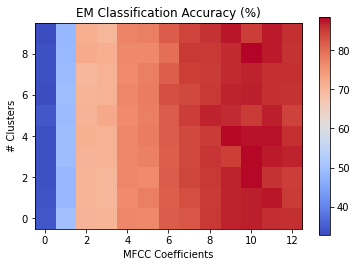

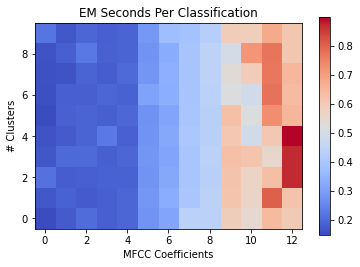

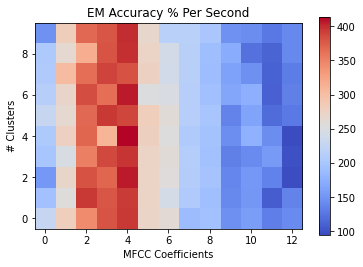

In [23]:
mesh_all = []
out_filename = f"{WRITE_PATH}_em_reg.txt"
f = open(out_filename, "w")
f.close()

for use_coeffs in range(1,MAX_COEFFS+1):
    model_coeffs = range(use_coeffs)
    mesh_row = []

    for num_clusters in range(1,MAX_CLUSTERS+1):
        clusters = [num_clusters]*digits
        
        # Run model on parameters
        gauss_results = create_em_model(digits=digits, clusters=clusters, model_coeffs=model_coeffs, train_path=TRAIN_PATH)
        (summary_df, classify_df) = test_model(classify_every=classify_every, gauss_results=gauss_results, model_coeffs=model_coeffs, digits=digits)
        pi_df = get_pi_df(gauss_results=gauss_results)

        # Pump results into mesh grid
        (accuracy, time) = get_accuracy_time(summary_df=summary_df)
        mesh_results = MeshResults(accuracy=accuracy, time=time, conf=classify_df, summary=summary_df, coeffs=use_coeffs, clusters=num_clusters, gauss_results=gauss_results) 
        mesh_row.append(mesh_results)

        # Write output files and send useful printout
        prefix = name_files(use_coeffs=use_coeffs, num_clusters=num_clusters)

        # Useful printout for debug, save files
        time_stamp = dt.now().strftime("%m-%d %H:%M:%S")
        print(f"{time_stamp}\tCoeffs: {use_coeffs}\tClusters: {num_clusters}")
        # print(f"{prefix}: \n{summary_df.mean(axis=0)}\n")

        # Printout information to file
        f = open(out_filename, "a")
        f.write(f"{prefix}\t({time_stamp}): \n{summary_df.mean(axis=0)}\n\n")
        f.close()

    # end iteration over cluster count
    mesh_all.append(mesh_row)

    # Serialize periodically so we don't lose data
    SERIAL_PATH = "../../data/04_serial/"
    prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
    filename = f"{SERIAL_PATH}{prefix}_em_reg.pickle" # "../../data/04_serial/clust_test.pickle"
    serialize_mesh(obj=mesh_all, filename=filename)

# end for loop
save_results(mesh_all=mesh_all, model_type="em")

11-23 19:02:10	Coeffs: 1	Clusters: 1
11-23 19:02:59	Coeffs: 1	Clusters: 2
11-23 19:04:06	Coeffs: 1	Clusters: 3
11-23 19:05:37	Coeffs: 1	Clusters: 4
11-23 19:07:13	Coeffs: 1	Clusters: 5
11-23 19:09:14	Coeffs: 1	Clusters: 6
11-23 19:11:30	Coeffs: 1	Clusters: 7
11-23 19:14:06	Coeffs: 1	Clusters: 8
11-23 19:16:59	Coeffs: 1	Clusters: 9
11-23 19:19:47	Coeffs: 1	Clusters: 10
dumped 56451 bytes
11-23 19:20:26	Coeffs: 2	Clusters: 1
11-23 19:21:20	Coeffs: 2	Clusters: 2
11-23 19:22:32	Coeffs: 2	Clusters: 3
11-23 19:23:54	Coeffs: 2	Clusters: 4
11-23 19:25:36	Coeffs: 2	Clusters: 5
11-23 19:27:36	Coeffs: 2	Clusters: 6
11-23 19:29:50	Coeffs: 2	Clusters: 7
11-23 19:32:22	Coeffs: 2	Clusters: 8
11-23 19:35:13	Coeffs: 2	Clusters: 9
11-23 19:38:22	Coeffs: 2	Clusters: 10
dumped 129885 bytes
11-23 19:39:03	Coeffs: 3	Clusters: 1
11-23 19:40:00	Coeffs: 3	Clusters: 2
11-23 19:41:20	Coeffs: 3	Clusters: 3
11-23 19:43:02	Coeffs: 3	Clusters: 4
11-23 19:44:56	Coeffs: 3	Clusters: 5
11-23 19:47:18	Coeffs: 3	Clusters:

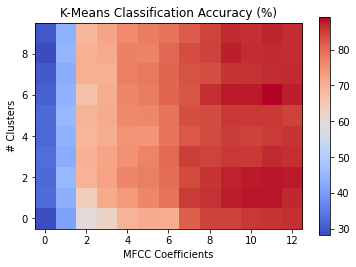

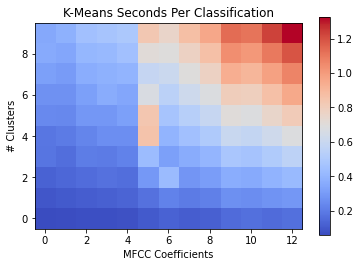

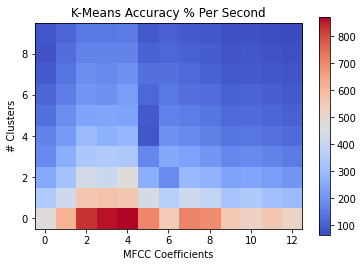

In [24]:
mesh_all = []
out_filename = f"{WRITE_PATH}_kmeans_reg.txt"
f = open(out_filename, "w")
f.close()

for use_coeffs in range(1,MAX_COEFFS+1):
    model_coeffs = range(use_coeffs)
    mesh_row = []

    for num_clusters in range(1,MAX_CLUSTERS+1):
        clusters = [num_clusters]*digits
        
        # Run model on parameters
        gauss_results = create_gauss_model(digits=digits, clusters=clusters, model_coeffs=model_coeffs, train_path=TRAIN_PATH)
        (summary_df, classify_df) = test_model(classify_every=classify_every, gauss_results=gauss_results, model_coeffs=model_coeffs, digits=digits)
        pi_df = get_pi_df(gauss_results=gauss_results)

        # Pump results into mesh grid
        (accuracy, time) = get_accuracy_time(summary_df=summary_df)
        mesh_results = MeshResults(accuracy=accuracy, time=time, conf=classify_df, summary=summary_df, coeffs=use_coeffs, clusters=num_clusters, gauss_results=gauss_results) 
        mesh_row.append(mesh_results)

        # Write output files and send useful printout
        prefix = name_files(use_coeffs=use_coeffs, num_clusters=num_clusters)

        # Useful printout for debug, save files
        time_stamp = dt.now().strftime("%m-%d %H:%M:%S")
        print(f"{time_stamp}\tCoeffs: {use_coeffs}\tClusters: {num_clusters}")

        # Printout information to file
        f = open(out_filename, "a")
        f.write(f"{prefix}\t({time_stamp}): \n{summary_df.mean(axis=0)}\n\n")
        f.close()

    # end iteration over cluster count
    mesh_all.append(mesh_row)

    # Serialize periodically so we don't lose data
    SERIAL_PATH = "../../data/04_serial/"
    prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
    filename = f"{SERIAL_PATH}{prefix}_kmeans_reg.pickle" # "../../data/04_serial/clust_test.pickle"
    serialize_mesh(obj=mesh_all, filename=filename)

# end for loop
save_results(mesh_all=mesh_all, model_type="kmeans")